In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import arctan2, cos, sin, sqrt

## System Identification for the Perching Glider

In this problem we will be implementing the system identification algorithm for the perching glider described in [this paper](https://groups.csail.mit.edu/robotics-center/public_papers/Hoburg09a.pdf) (everything you need will be in the notebook but it's a quick read, so we encourage you to give it a look!). We will be simulating "ground truth" measurements around an approximate perching trajectory, and we will then search over sets of physically-inspired basis functions in order to choose the set that best fits the dynamics of our glider in a least-squares sense. This problem is just a short glimpse into some of the interesting work done on the perching glider task. For some interesting references take a look at sections [10.5](https://underactuated.csail.mit.edu/trajopt.html#perching), [18.2](https://underactuated.csail.mit.edu/sysid.html#lumped) in the notes, and [this thesis](https://groups.csail.mit.edu/robotics-center/public_papers/Moore14b.pdf).

**These are the main steps of the notebook:**
1. Implement the normal equation to solve the least squares problem.
2. Implement least squares fitting and identify the best set of basis functions.
3. Write the basis dynamics for the perching glider.
4. Answer the written questions at the bottom of the notebook and submit
them to gradescope in a .pdf

Note that in order to pass the autograder, you do not need to tune any hyperparameters! This includes random seeds, number of trajectories, or simulation/system parameters. Feel free to play around with these, but set them to the original values when you want to test with the autograder.

## Modeling the Glider
In the figure below we see a model of our glider. The glider has horizontal position $x$, vertical position $z$, and pitch $\theta$. We control our glider by actuating a control surface located at the tail called the "elevator" ($u = \dot \phi$). The forces depicted denote the force normal to the wing $f_w$ and normal to the elevator $f_e$. The full state of our glider is as follows:

$$q = [x, z, \theta, \phi, \dot x, \dot z, \dot \theta]^T$$

$$\dot q = [\dot x, \dot z, \dot \theta, u, \ddot x, \ddot z, \ddot \theta]^T$$

<img src="https://raw.githubusercontent.com/RussTedrake/underactuated/master/book/figures/glider.svg" width="400">

The equations of motion below were verified to work well in experiments. These equations describe a "flat plate model", where the complex lift and drag forces on the wing or the tail can be simplified as one normal force exerted at the center of pressure of either surface

$$f_n(S, n, v) = -\rho S(n\cdot v) |v|$$

where $\rho$ is the density of the medium, $S$ is the surface area of the wing, $\alpha$ is the angle of attack of the wing, $n$ is the normal vector of the lifting surface, and $v$ is the velocity of the center of pressure relative to the air. Below, $I$ is the moment of inertia of the glider, and $m$ is the mass of the glider:

$$f_w = f_n(S_w, n_w, \dot p_w), \;\;\; f_e = f_n(S_e, n_e, \dot p_e)$$

$$\ddot x = \frac{1}{m} (f_w \sin(\theta) + f_e \sin(\theta + \phi))$$

$$\ddot z = \frac{1}{m} (f_w \cos(\theta) + f_e \cos(\theta + \phi))$$

$$\ddot \theta = \frac{1}{I} (l_w f_w + (l_h \cos(\phi) + l_e)f_e)$$

We start by simulating a "ground truth" for our glider using the equations of motion above. In the original experiment, the dynamics were fit directly from measured data. The glider was thrown into a motion-capture environment that recorded positions as it executed a hand tuned controller that allowed it to track an approximate "perching trajectory":

<img src="https://raw.githubusercontent.com/RussTedrake/underactuated/master/book/figures/perch-sequence.jpg" width="800">

These position measurements were then differentiated to generate velocities and accelerations. Because we do not have a "real" system, we instead use the above equations of motion to simulate a system and collect data. We then use least squares to fit a linear combination of basis functions in order to approximate our dynamics. Below, we define the physical parameters of our system globally, and we implement a dynamics class that we will use to simulate our system and collect data trajectories. We also define two plotting helper functions that we use throughout the notebook.




In [2]:
# Global physical parameters
m = 0.08  # body mass.
Sw = 0.0885  # surface area of wing + fuselage + tail.
Se = 0.0147  # surface area of elevator.
I = 0.0015  # body inertia.
lw = 0  # horizontal offset of wing center.
le = 0.022  # elevator aerodynamic center from hinge.
lh = 0.27  # elevator hinge.
rho = 1.204  # air density (kg/m^3).
g = 9.81  # gravity.

In [3]:
def plot_glider(states, label=None):
    """Plot the x,z,theta positions represented
    in the states argument.
    """
    x = list(states[:, 0])
    z = list(states[:, 1])
    pitch = list(states[:, 2])
    linelength = 0.2
    if label is not None:
        plt.plot(x, z, label=label)
    else:
        plt.plot(x, z)
    glider_idxs = [0, int(N / 2), -1]
    for i in glider_idxs:
        xi, zi, pitchi = x[i], z[i], pitch[i]
        xi = [xi - linelength * cos(-pitchi), xi + linelength * cos(-pitchi)]
        zi = [zi - linelength * sin(-pitchi), zi + linelength * sin(-pitchi)]
        plt.plot(xi, zi, "-", color="blue")
    plt.xlabel("X distance")
    plt.ylabel("Z distance")
    if label is not None:
        plt.legend()


def plot_fits(values, times, color, label, titles, fig=None, axs=None):
    if axs is None:
        fig, axs = plt.subplots(1, 3, figsize=[15, 5])
    for i in range(3):
        axs[i].plot(times, values[:, i], "tab:{}".format(color), label=label)
        axs[i].set_title(titles[i])
    fig.tight_layout()
    plt.legend()
    return fig, axs

In [4]:
class TrueDynamics:
    def __init__(self, dt):
        self.dt = dt

    def get_forces(self, q, u):
        # q = generalized coordinates and velocities
        x, z, th, phi, x_dot, z_dot, th_dot = q
        # xwdot, zwdot = rate of change of wing location
        xwdot = x_dot + lw * th_dot * sin(th)
        zwdot = z_dot + lw * th_dot * cos(th)
        # vw = velocity of wing
        vw = sqrt(zwdot**2 + xwdot**2)
        # fw = normal force on wing
        fw = -rho * Sw * (sin(th) * xwdot + cos(th) * zwdot) * vw
        # elevator angle
        e = th + phi
        # rate of change of elevator angle
        edot = th_dot + u
        xedot = x_dot + lh * th_dot * sin(th) + le * edot * sin(e)
        zedot = z_dot + lh * th_dot * cos(th) + le * edot * cos(e)
        ve = sqrt(zedot**2 + xedot**2)
        # flat plate elevator normal force
        fe = -rho * Se * (sin(e) * xedot + cos(e) * zedot) * ve
        return fw, fe

    def next_state(self, q, u):
        x, z, th, phi, x_dot, z_dot, th_dot = q
        q_dot = np.zeros(q.shape)
        q_dot[:3] = q[4:] # velocities = velocities
        q_dot[3] = u # direct control of velocity (not control affine)
        fw, fe = self.get_forces(q, u)
        x_ddot = 1 / m * (fw * sin(th) + fe * sin(th + phi)) # translational forces
        z_ddot = (1 / m * (fw * cos(th) + fe * cos(th + phi))) - g
        th_ddot = (fw * lw + fe * (lh * cos(phi) + le)) / I
        q_dot[4] = x_ddot
        q_dot[5] = z_ddot
        q_dot[6] = th_ddot
        # forward Euler integration
        q_next = q + self.dt * q_dot
        return q_next, q_dot

    def convert_to_plane(self, q_dot, q):
        """Converts "world" frame accelerations
        [x_ddot, z_ddot, th_ddot] to "plane" frame
        accelerations [xp_ddot, zp_ddot, thp_ddot].
        """
        x_ddot, z_ddot, th_ddot = q_dot[4:]
        th = q[2]
        xp_ddot = cos(th) * x_ddot + sin(th) * (z_ddot + g)
        zp_ddot = -sin(th) * x_ddot + cos(th) * (z_ddot + g)
        return np.array([xp_ddot, zp_ddot, th_ddot])

# Collecting Data Trajectories

Now that we have our simulated glider dynamics, we can collect measurements of the state $q$ and $\dot q$ as our glider flies different trajectories. We collect 15 trajectories, each of which starts with the glider being launched the forward roughly horizontally. While the glider is flying we execute a predetermined controller that approximately "perches" the glider. Each trajectory injects some random noise into this controller in order to capture a variety of different states in the dataset. We record the states and the accelerations for each of the trajectories, but we also collect accelerations in the "plane" frame. We will expand on this in the next section. We plot all the glider trajectories collected below.

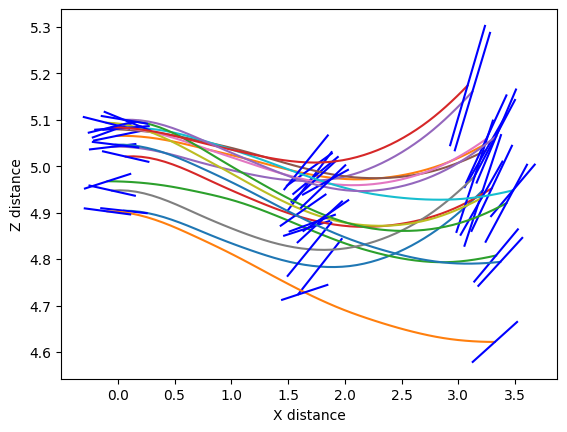

In [5]:
# Global simulation parameters
dt = 0.01  # timestep duration
N = 50  # number of timesteps

# Collect data trajectories
np.random.seed(10)
dynamics_gt = TrueDynamics(dt)

trajectories = dict()
times = [t * dt for t in range(N + 1)]
for traj in range(15):
    q0 = np.array(
        [0.0, 5.0, 0.0, 0.0, 7.0, 0.0, 0.0]
    )  # [x, z, theta, phi, x_dot, z_dot, theta_dot]
    q0 += np.random.uniform(-0.1, 0.1, 7)
    q = q0
    states = [q]  # [q_0, ..., q_N]
    accels = []  # [qdd_0, ..., qdd_N-1] ("world" coordinates)
    accels_p = []  # [qddp_0, ..., qddp_N-1] ("plane" coordinates)
    torques = [
        6.15395591,
        7.28319761,
        -1.83089634,
        4.58240618,
        0.45388034,
        1.06884147,
        6.68525636,
        -6.73814984,
        -6.48535779,
        -7.53639179,
        5.22478032,
        4.36927603,
        5.81213723,
        7.51811934,
        4.69917174,
        -0.60508076,
        4.406542,
        -5.9961313,
        2.19787426,
        -5.60219346,
        6.98484302,
        0.34319264,
        -1.34048711,
        -3.6983518,
        4.30765272,
        -0.68878897,
        1.07495796,
        -7.55883214,
        1.84781407,
        1.7607955,
        1.83679493,
        6.97037852,
        2.85602658,
        -2.20684474,
        -0.98909976,
        3.10438357,
        -6.90796214,
        2.61956544,
        2.68037339,
        -4.54930009,
        -5.82881209,
        -2.89924468,
        -2.1408262,
        1.10264829,
        -0.96444517,
        7.67135831,
        -6.2510655,
        -4.57295322,
        -5.32013765,
        2.40501995,
    ]
    torques += np.random.uniform(-1.0, 1.0, N)
    for i in range(N):
        q, q_dot = dynamics_gt.next_state(q, torques[i])
        states.append(q)
        accels.append(q_dot)
        accels_p.append(dynamics_gt.convert_to_plane(q_dot, states[-2]))
    plot_glider(np.array(states))
    trajectories[traj] = [states, accels, accels_p, torques, q0]

# Fitting Basis Functions

Now that we have our data $q$ and $\dot q$, we want to search over a set of basis functions to see which ones best capture our dynamics. Below, we define a set of physically inspired basis functions for you - these are a direct subset of the basis functions used in [the paper](https://groups.csail.mit.edu/robotics-center/public_papers/Hoburg09a.pdf) (see the appendix for all 41). They should be numbered according to the paper.

These basis functions are a function of our state $q$, but they take a variety of intermediate variables $V$, $V_{el}$, $\alpha$, and $\alpha_{el}$ as arguments. These variables are functions of the state/physical parameters, and they represent physical values like the total velocity of the glider and the elevator ($V$ and $V_{el}$) or the angle of attack of the wing and the elevator ($\alpha$ and $\alpha_{el}$).

In [6]:
f1 = lambda q, V, a, Vel, ael, u: V**2 * sin(a)
f3 = lambda q, V, a, Vel, ael, u: V**2 * sin(a) * cos(a) ** 2
f5 = lambda q, V, a, Vel, ael, u: V**2 * sin(a) ** 3
f6 = lambda q, V, a, Vel, ael, u: V**2 * cos(a) ** 3
f7 = lambda q, V, a, Vel, ael, u: V**3 * cos(a)
f9 = lambda q, V, a, Vel, ael, u: V * q[6] * cos(a)
f11 = lambda q, V, a, Vel, ael, u: q[6]
f13 = lambda q, V, a, Vel, ael, u: sin(q[3])
f15 = lambda q, V, a, Vel, ael, u: V * u * sin(q[3])
f18 = lambda q, V, a, Vel, ael, u: V * (q[6] + u) * sin(q[3]) * cos(q[3])
f20 = lambda q, V, a, Vel, ael, u: Vel**2 * sin(ael)
f24 = lambda q, V, a, Vel, ael, u: Vel**2 * sin(ael) * sin(q[3])
f26 = lambda q, V, a, Vel, ael, u: Vel * u * cos(ael)
f29 = lambda q, V, a, Vel, ael, u: V**2 * sin(a) * cos(a)
f30 = lambda q, V, a, Vel, ael, u: Vel**2 * sin(ael) * cos(ael) * cos(q[3])
f32 = lambda q, V, a, Vel, ael, u: q[6] * abs(q[6])
f35 = lambda q, V, a, Vel, ael, u: q[6] * abs(q[6]) * cos(a)
f38 = lambda q, V, a, Vel, ael, u: Vel * (q[6] + u)
f39 = lambda q, V, a, Vel, ael, u: Vel * (q[6] + u) * sin(ael)
f41 = lambda q, V, a, Vel, ael, u: Vel * (q[6] + u) * sin(ael) * cos(ael)

In order to find the best combination of basis functions that fit our dynamics we use the "plane" frame accelerations collected above (as opposed to the "world" frame accelerations also collected). The equations of motion above are expressed in the world frame. However, the use of a flat plate wing allows us to express accelerations as normal and tangential to the wing instead of normal and tangential to the velocity. These "plane" frame accelerations are more decoupled than the world frame accelerations. The transform to convert from world frame to plane frame accelerations is shown below. Because we only care about fitting accelerations due to aerodynamic forces note that we also remove gravity from $\ddot z$.

$$\begin{bmatrix} \ddot{x}_p \\  \ddot{z}_p \\ \ddot{\theta}_p \end{bmatrix} = \begin{bmatrix} \cos{(\theta)} & \sin{(\theta)} & 0 \\ -\sin{(\theta)} & \cos{(\theta)} & 0 \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} \ddot{x} \\  \ddot{z} + g \\ \ddot{\theta} \end{bmatrix}$$

We can now use the trajectory data we collected to fit a linear combination of basis functions $\phi$ using least-squares to the accelerations we collected in the plane frame of reference. Mathematically, for each acceleration element we want to go through sets of candidate basis functions $\phi$ and fit coefficients $\beta$ using least-squares and we want to find the set that minimizes the prediction residual:

$$ \hat{\ddot x}_p = \sum_{j \in s_x} \beta_j^x \phi_j $$

$$ \hat{\ddot z}_p = \sum_{j \in s} \beta_j^z \phi_j $$

$$ \hat{\ddot \theta}_p = \sum_{j \in s} \beta_j^\theta \phi_j $$

Here $s_x$ represents the subset of available basis functions that minimize the prediction residual $\sum_i (\hat{\ddot x}_i - \ddot x_i)^2$ over all our sampled measurements $\ddot x_i$ (same goes for $s_z$ and $s_{\theta}$, with measurements $\ddot z_i$ and $\ddot \theta_i$).

Below, we define two helper functions we will use throughout the rest of the notebook. The method `get_intermediates` takes in the state $q$ and returns intermediate values $V$, $V_{el}$, $\alpha$ and $\alpha_{el}$. The method `get_basis_output` computes $\hat{\ddot x}_{p}$, $\hat{\ddot z}_{p}$, and $\hat{\ddot \theta}_{p}$ given a set of basis functions for each acceleration and their associated betas, as well as intermediate variables, the state and the input.

In [7]:
def get_intermediates(q):
    """From the state q, calculate the following
    intermediate values used when computing the
    basis functions.

    V : total velocity
    a : angle of attack of the wing
    Vel : total velocity of the elevator
    ael : angle of attack of the elevator
    """
    x, z, th, phi, x_dot, z_dot, th_dot = q
    V = sqrt(x_dot**2 + z_dot**2)
    a = th - arctan2(z_dot, x_dot)
    xel_dot = x_dot + (le + lh) * th_dot * sin(th)
    zel_dot = z_dot - (le + lh) * th_dot * cos(th)
    Vel = sqrt(xel_dot**2 + zel_dot**2)
    ael = th + phi - arctan2(zel_dot, xel_dot)
    return V, a, Vel, ael


def get_basis_output(q, V, a, Vel, ael, u, basis, betas):
    """Given a set of basis functions, their
    betas, intermediate values, the state and
    the torque, compute accelerations in "plane"
    coordinates (xp_ddot, zp_ddot, thp_ddot).
    """
    xp_ddot = 0
    for i in range(len(basis[0])):
        f = basis[0][i]
        b = betas[0][i]
        xp_ddot += b * f(q, V, a, Vel, ael, u)
    zp_ddot = 0
    for i in range(len(basis[1])):
        f = basis[1][i]
        b = betas[1][i]
        zp_ddot += b * f(q, V, a, Vel, ael, u)
    thp_ddot = 0
    for i in range(len(basis[2])):
        f = basis[2][i]
        b = betas[2][i]
        thp_ddot += b * f(q, V, a, Vel, ael, u)
    return np.array([xp_ddot, zp_ddot, thp_ddot])

# Solving Least Squares

Given a specific set of basis functions to test, we need to find the $\beta$ coefficients that minimize the least-squares problem with respect to the measurement data we collected. For each we need to solve three least squares problems (one for each acceleration element). Let's say we are solving the least-squared problem for $\ddot x_p$. In matrix form, we want to solve the following for the best fit coefficients $C$:

$$X \cdot C = Y$$

Here $X$ represents the basis function outputs for the basis functions $\phi_1, \dots, \phi_N$ we have chosen to represent $\hat{\ddot x}_p$. Next, $Y$ represents the $M$ target values $\ddot x_p$ in our dataset. $C$ is a column vector containing the $N$ different $\beta$ coefficients to fit (one for each basis function). Expanded out, the above equation looks like this:

$$\begin{bmatrix} \phi_1(q^1) & \dots & \phi_N(q^1) \\ \vdots & \ddots & \vdots \\ \phi_1(q^{M}) & \dots & \phi_N(q^{M}) \end{bmatrix} \begin{bmatrix} \beta_1^x \\ \vdots \\ \beta_N^x \end{bmatrix}
= \begin{bmatrix} \ddot x_p^1 \\ \vdots \\ \ddot x_p^M \end{bmatrix}$$

The least-squares solution can be found analytically using the normal equation:

$$C = (X^T X)^{-1} X^T Y$$

Your job below is to fill out the `least_squares` method below by implementing the normal equation given matrices $X$ and $Y$.


In [8]:
def least_squares(X, Y):
    ################## TODO ##################
    # Given data X and Y, write the normal equation
    # to solve the least squares problem XC = Y for the
    # coefficient matrix C
    C = np.zeros(X.shape[1])
    ##########################################
    C = np.linalg.solve(X.T @ X, X.T @ Y)
    return C

# Choosing the Best Basis Set

In the cell below we now define 10 candidate basis configurations we'd like to try out. Each set contains lists of basis functions used to compute $\hat{\ddot x}_p$, $\hat{\ddot z}_p$, and $\hat{\ddot \theta}_p$ respectively. Eventually we will update the configurations with the least-squares solution betas, and the one-step residuals summed over all sample points in our dataset. Note that in the paper, they try all combinations of the basis functions up to 3 basis functions per acceleration (meaning they use at most 3 basis functions to compute an acceleration). To save some time we include only 10 different combinations, with the best combination included. The methodology is the same. Nowadays, there exist a variety of algorithms we might use to search over basis functions (e.g. https://en.wikipedia.org/wiki/Lasso_(statistics) ).

Your job is to fill in the code marked `#TODO` and use the `least_squares` method you defined above to perform . This should just be one line of code, but be sure you look through the code and understand what `basis_outputs_i` and `accels_p` represent.

In [9]:
basis_configs = (
    {  # basis id : (functions [x, z, theta], betas [x, z, theta], fit_score)
        1: ([[f1, f15], [f11], [f38, f32]], [[1, 1], [1], [1, 1]], 0),
        2: ([[f41], [f26, f20], [f3, f38, f35]], [[1], [1, 1], [1, 1, 1]], 0),
        3: ([[f26, f5], [f11], [f7, f9]], [[1, 1], [1], [1, 1]], 0),
        4: (
            [[f35, f3, f1], [f11, f13, f30], [f7, f9]],
            [[1, 1, 1], [1, 1, 1], [1, 1]],
            0,
        ),
        5: ([[f9], [f41, f26], [f11]], [[1], [1, 1], [1]], 0),
        6: (
            [[f7, f24], [f1, f6, f9], [f29, f30]],
            [[1, 1], [1, 1, 1], [1, 1]],
            0,
        ),
        7: ([[f38], [f32], [f11]], [[1], [1], [1]], 0),
        8: ([[f39, f18], [f9], [f5, f30]], [[1, 1], [1], [1, 1]], 0),
        9: ([[f15, f6], [f35, f41], [f18, f3]], [[1, 1], [1, 1], [1, 1]], 0),
        10: ([[f1, f20, f24], [f26], [f7]], [[1, 1, 1], [1], [1]], 0),
    }
)

# Concatenate data from all trajectories
states = []  # Mx7 matrix representing all M measured states
accels_p = []  # Mx3 matrix representing all M measured plane frame accelerations
torques = np.array([])
for traj in list(trajectories.values())[1:]:
    states += traj[0][:-1]
    accels_p += traj[2]
    torques = np.concatenate((torques, traj[3]), axis=0)

# Fit each basis set to all data points
for c in basis_configs.keys():
    basis, _, _ = basis_configs[c]
    betas_fit = []
    for i in range(3):  # iterate through each acceleration element
        basis_outputs_i = [] # M x i
        for j in range(len(states)):  # iterate through all data points
            V, a, Vel, ael = get_intermediates(states[j])
            output = []
            for f in basis[i]:
                output.append(f(states[j], V, a, Vel, ael, torques[j]))
            basis_outputs_i.append(output)
        accels_p = np.array(accels_p)
        basis_outputs_i = np.array(basis_outputs_i)
        ################## TODO ##################
        # Use the least_squares method you defined
        # above to perform a fit. You will need
        # basis_outputs_i and accels_p.
        # basis_outputs_i @ betas = accels_p
        # betas = (b_o_i.T @ b_o_i)^-1 @ b_o_i.T @ accels_p
        betas = least_squares(basis_outputs_i, accels_p[:,i])
        ##########################################
        betas_fit.append(betas)

    # Compute residual score
    accels_p_hat = []
    for i in range(len(states)):
        q = states[i]
        u = torques[i]
        V, a, Vel, ael = get_intermediates(q)
        accels_p_hat.append(get_basis_output(q, V, a, Vel, ael, u, basis, betas_fit))

    fit_score = np.sum((np.array(accels_p_hat) - accels_p) ** 2)
    basis_configs[c] = (basis, betas_fit, fit_score)

best_score = np.inf
for config in basis_configs:
    print("Config {}".format(config))
    basis, betas_fit, fit_score = basis_configs[config]
    print("Score: {}".format(int(fit_score)))
    if fit_score < best_score:
        best_score = int(fit_score)
        best_config = config
    print("-" * 100)
print("Best Config: {}".format(best_config))

Config 1
Score: 113727
----------------------------------------------------------------------------------------------------
Config 2
Score: 183944
----------------------------------------------------------------------------------------------------
Config 3
Score: 120629
----------------------------------------------------------------------------------------------------
Config 4
Score: 104607
----------------------------------------------------------------------------------------------------
Config 5
Score: 192647
----------------------------------------------------------------------------------------------------
Config 6
Score: 63831
----------------------------------------------------------------------------------------------------
Config 7
Score: 157343
----------------------------------------------------------------------------------------------------
Config 8
Score: 96418
----------------------------------------------------------------------------------------------------
Config 9
S

# Simulating Basis Dynamics

Now that we've found the best set of basis functions we want to simulate our system using our basis function dynamics model to see how good our fit is.

Your job is to fill in the section marked `#TODO` in the `next_state` method of the `BasisDynamics` class below. You will need to use the helper functions `get_intermediates` and `get_basis_output` and `self.convert_to_world` in order to compute $\dot q$ in the world frame. Make sure you set `accels_p` to be an array with the plane frame accelerations $[\ddot x_p, \ddot z_p, \ddot \theta_p]$.

In [10]:
class BasisDynamics:
    def __init__(self, funcs, betas, dt):
        self.basis = funcs
        self.betas = betas
        self.dt = dt

    def next_state(self, q, u):
        x, z, th, phi, x_dot, z_dot, th_dot = q
        q_dot = np.zeros(q.shape)
        ################## TODO ##################
        # Fill in q_dot (world frame coordinates).
        # You will need to call get_intermediates,
        # get_basis_output, and self.convert_to_world.
        # You can access the basis and betas as class
        # attributes. Make sure you set accels_p
        # to the plane frame accelerations
        # xp_ddot, zp_ddot, thp_ddot.
        q_dot[0] = x_dot
        q_dot[1] = z_dot
        q_dot[2] = th_dot
        q_dot[3] = u
        V, a, Vel, ael = get_intermediates(q)
        accels_p = get_basis_output(q, V, a, Vel, ael, u, self.basis, self.betas)
        accels = self.convert_to_world(accels_p, th)
        q_dot[4] = accels[0]
        q_dot[5] = accels[1]
        q_dot[6] = accels[2]
        ##########################################
        q_next = q + self.dt * q_dot
        return q_next, q_dot, accels_p

    def convert_to_world(self, accels_p, th):
        """Converts "plane" frame accelerations
        [xp_ddot, zp_ddot, thp_ddot] to "world" frame
        accelerations [x_ddot, z_ddot, th_ddot].
        """
        A = np.array([[cos(th), sin(th), 0], [-sin(th), cos(th), 0], [0, 0, 1]])
        A_inv = np.linalg.inv(A)
        q = np.dot(A_inv, accels_p)
        q[1] = q[1] - g
        return q

In [11]:
# Simulate test trajectory for the best fit basis
traj = trajectories[0]
states, accels, accels_p, torques, q0 = traj

dynamics_hat = BasisDynamics(
    basis_configs[best_config][0], basis_configs[best_config][1], dt
)
states_hat = [q0]
accels_hat = []
accels_p_hat = []
q = q0
for i in range(N):
    q, q_dot, q_ddot_p = dynamics_hat.next_state(q, torques[i])
    states_hat.append(q)
    accels_hat.append(q_dot)
    accels_p_hat.append(q_ddot_p)
trajectories_fit = [states_hat, accels_hat, accels_p_hat, torques, q0]

# Plotting Results
We can now plot our results to see how well our chosen basis functions describe the dynamics of our system! Run the cells below to plot our fits to each state variable, and plot the measured and simulated trajectories. These fits will not be perfect but should be somewhat close to the measurements.

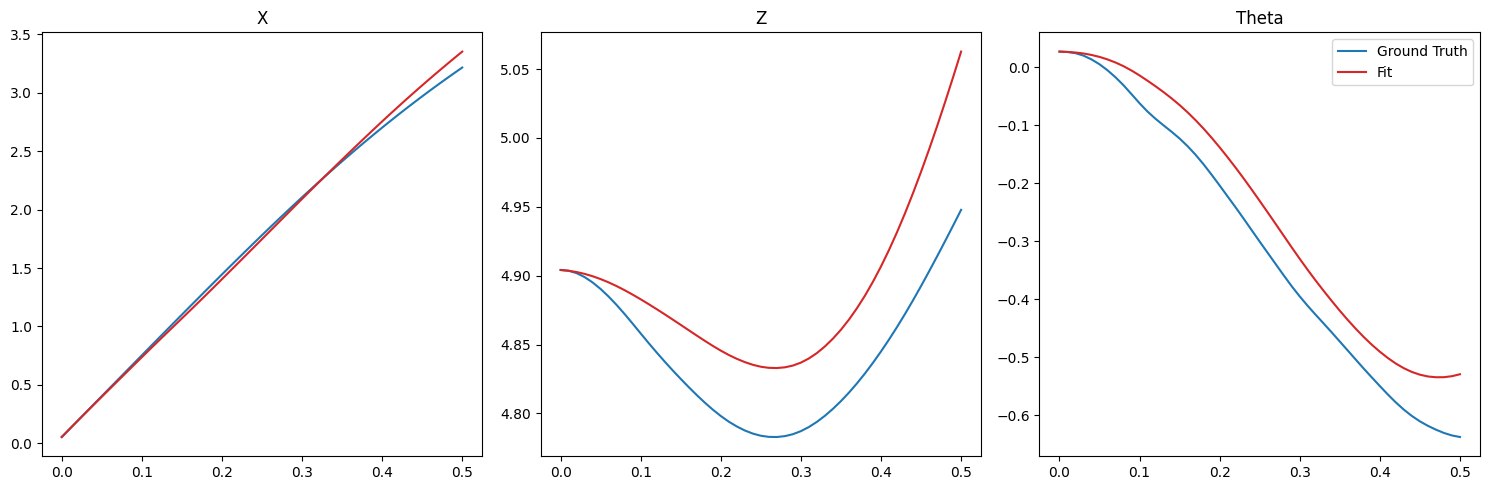

In [12]:
fig, axs = plot_fits(
    np.array(states), times, "blue", "Ground Truth", ["X", "Z", "Theta"]
)
_, _ = plot_fits(
    np.array(states_hat),
    times,
    "red",
    "Fit",
    ["X", "Z", "Theta"],
    fig=fig,
    axs=axs,
)

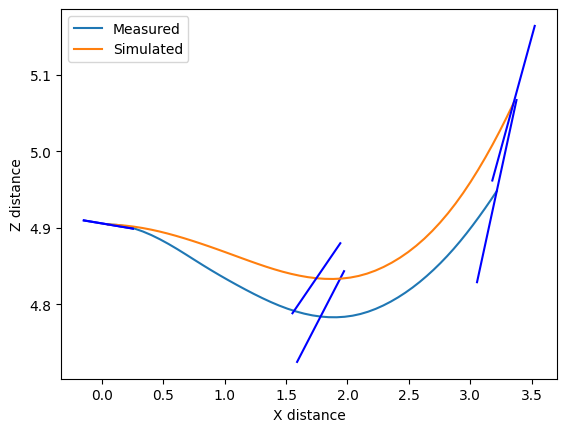

In [13]:
plot_glider(np.array(states), label="Measured")
plot_glider(np.array(states_hat), label="Simulated")

## Written Questions

1) Work through the coding sections in this notebook.

2) All of the basis configurations we tested used at most 3 basis functions to compute a single acceleration. If we increase the number of basis functions used to compute a single acceleration to 4, the least-squares residual goes down. Why would we limit ourselves to 3 basis functions if by using more we can generate a better fit?


## Autograding
You can check your work by running the following cell. We will look at the values for the variables `best_config`, `best_score`, and we will look at the trajectory you simulated with the basis dynamics `states_hat`. You will get points for the following:

1) If the least squares fit is implemented correctly and you find the correct `best_config` with the correct `best_score`.

2) If you implemented basis dynamics correctly, and your simulated trajectory `states_hat` is correct.

In [14]:
from underactuated.exercises.grader import Grader
from underactuated.exercises.sysid.test_glider_sysid import TestGliderSysid

Grader.grade_output([TestGliderSysid], [locals()], "results.json")
Grader.print_test_results("results.json")

Total score is 6/6.

Score for Test basis function dynamics is 3/3.

Score for Test least squares fitting is 3/3.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8f8d3fd5-f29b-43b9-a0d4-4cee1c8b244e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>